In [1]:
# SKIP THIS IF YOU WANT TO USE THE NON WEB INTERFACE (can only be done when notebook run locally)
%matplotlib inline

In [2]:
#%%
try:
    %load_ext autoreload
    %autoreload 2
    print 1
except:
    print 'NOT IPYTHON'

# import matplotlib as mpl
# mpl.use('TKAgg')
from matplotlib import pyplot as plt
#plt.ion()

import sys
import numpy as np
import ca_source_extraction as cse
from scipy.sparse import coo_matrix
import tifffile
import subprocess
import time as tm
from time import time
import pylab as pl
import psutil
import glob
import os


1


In [3]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib.cm as cm

bpl.output_notebook()

Loading BokehJS ...

In [4]:
#%%
n_processes = np.maximum(np.int(psutil.cpu_count()*.75),1) # roughly number of cores on your machine minus 1
print 'using ' + str(n_processes) + ' processes'
print "Stopping  cluster to avoid unnencessary use of memory...."
sys.stdout.flush()  
cse.utilities.stop_server()

using 3 processes
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
No cluster to stop... done


In [5]:
try:
    t = tifffile.TiffFile('movies/demoMovie.tif') 
except:
    # create 3d tiff
    from scipy.io import loadmat
    mat = loadmat('../ROI_detect/Datasets/data_exp3D')
    data = np.transpose(mat['data'], [3, 0, 1, 2])
    data -= data.min()
    data *= (2**15-1)/data.max()
    data = data.astype(np.uint16)
    t = tifffile.TiffWriter('movies/demoMovie3D.tif', imagej=True)
    t.save(np.transpose(data, [1,0, 2, 3]))
    t.close()
    # change properties in ImageJ to 100 frames 1 channels and save changes

In [6]:
Yr = t.asarray().astype(dtype=np.float32) 
T, dims = Yr.shape[0], Yr.shape[1:]
Yr = np.transpose(Yr, range(1,Yr.ndim)+[0])
Yr=np.reshape(Yr,(np.prod(dims),T),order='F')

In [7]:
T,dims

(2000, (60, 80))

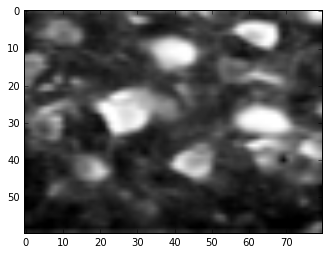

In [8]:
np.save('Yr',Yr)
Yr=np.load('Yr.npy',mmap_mode='r')  
# Yr,d1,d2,T=cse.utilities.load_memmap(fname_new)
Y=np.reshape(Yr,dims+(T,),order='F')
Cn = cse.utilities.local_correlations(Y)
plt.imshow(Cn.max(0) if len(Cn.shape)==3 else Cn, cmap='gray',vmin=np.percentile(Cn, 1), vmax=np.percentile(Cn, 99))    
plt.show()

In [9]:
#%%
K=30 # number of neurons expected per patch
gSig=[5,5] # expected half size of neurons
merge_thresh=0.8 # merging threshold, max correlation allowed
p=2 #order of the autoregressive system
options = cse.utilities.CNMFSetParms(Y,n_processes,p=p,gSig=gSig,K=K)
cse.utilities.start_server(options['spatial_params']['n_processes'])

using 3 processes
Starting cluster.................

In [10]:
# options['spatial_params']['method'] = 'dilate'

In [11]:
#%% PREPROCESS DATA AND INITIALIZE COMPONENTS
t1 = time()
Yr,sn,g,psx = cse.pre_processing.preprocess_data(Yr,**options['preprocess_params'])
Atmp, Ctmp, b_in, f_in, center=cse.initialization.initialize_components(Y, **options['init_params'])                                                    
print time() - t1

Running on 3 engines.
Noise Normalization
Roi Extraction...
Refining Components...
5.4326941967


In [12]:
refine_components=False
if refine_components:
    Ain,Cin = cse.utilities.manually_refine_components(Y,options['init_params']['gSig'],coo_matrix(Atmp),Ctmp,Cn,thr=0.9)
else:
    Ain,Cin = Atmp, Ctmp

In [13]:
pl.close('all')

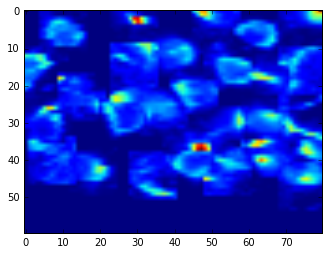

In [14]:
plt.figure()
plt.imshow(Ain.reshape(dims+(K,),order='F').max(-1));

In [15]:
p1=cse.nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [16]:
#%% UPDATE SPATIAL COMPONENTS
t1 = time()
A,b,Cin = cse.spatial.update_spatial_components(Yr, Cin, f_in, Ain, sn=sn, **options['spatial_params'])
t_elSPATIAL = time() - t1
print t_elSPATIAL 
#clear_output(wait=True)
print('DONE!')

 find search location
Updated Spatial Components
threshold
Computing A_bas
--- 4.68200588226 seconds ---
Remove temporary file created
4.68655395508
DONE!


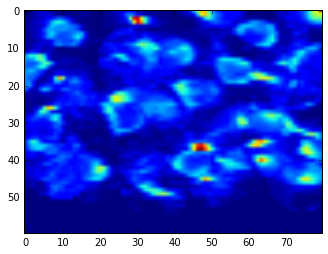

In [17]:
plt.figure()
plt.imshow(A.toarray().reshape(dims+(K,),order='F').max(-1));

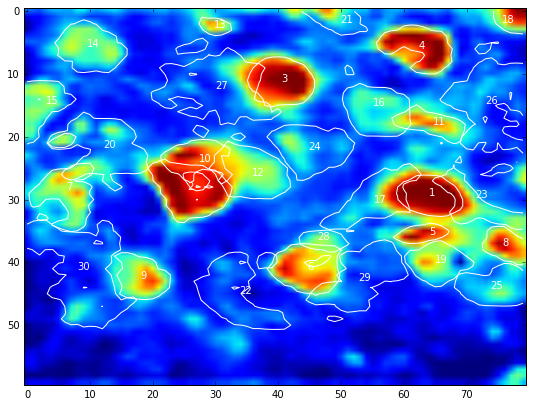

In [18]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = cse.utilities.plot_contours(A,Cn,thr=0.9)
plt.show()

In [19]:
pl.close('all')

In [20]:
p1=cse.nb_plot_contour(Cn,A.todense(),dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [21]:
pl.close()
t1 = time()
options['temporal_params']['p'] = 0 # set this to zero for fast updating without deconvolution
C,f,S,bl,c1,neurons_sn,g,YrA = cse.temporal.update_temporal_components(Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
t_elTEMPORAL = time() - t1
print t_elTEMPORAL  
clear_output(wait=True)

2 out of total 30 temporal components updated
4 out of total 30 temporal components updated
6 out of total 30 temporal components updated
10 out of total 30 temporal components updated
14 out of total 30 temporal components updated
17 out of total 30 temporal components updated
24 out of total 30 temporal components updated
30 out of total 30 temporal components updated
1 out of total 30 temporal components updated
3 out of total 30 temporal components updated
8 out of total 30 temporal components updated
14 out of total 30 temporal components updated
18 out of total 30 temporal components updated
22 out of total 30 temporal components updated
30 out of total 30 temporal components updated
stopping: overall temporal component not changing significantly
0.605835914612


In [22]:
#%% merge components corresponding to the same neuron
t1 = time()
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cse.merging.merge_components(Yr,A,b,C,f,S,sn,options['temporal_params'], options['spatial_params'], bl=bl, c1=c1, sn=neurons_sn, g=g, thr=0.8, mx=50, fast_merge = True)
t_elMERGE = time() - t1
print t_elMERGE  

[ 0 16 22]
0.0231170654297


In [23]:
#refine spatial and temporal components
t1 = time()
A2,b2,C2 = cse.spatial.update_spatial_components(Yr, C_m, f, A_m, sn=sn, **options['spatial_params'])
options['temporal_params']['p'] = p # set it back to original value to perform full deconvolution
C2,f2,S2,bl2,c12,neurons_sn2,g21,YrA = cse.temporal.update_temporal_components(Yr,A2,b2,C2,f,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
print time() - t1
clear_output(wait=True)
print time() - t1 # 100 seconds
print('DONE!')

16.1468350887
DONE!


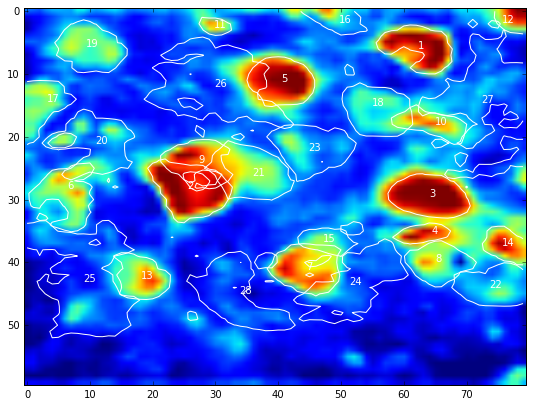

In [24]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
A_or, C_or, srt = cse.utilities.order_components(A2,C2)
crd = cse.utilities.plot_contours(coo_matrix(A_or),Cn,thr=0.9)
plt.show()

In [25]:
p2=cse.utilities.nb_plot_contour(Cn,A_or,dims[0],dims[1],thr=0.9,face_color='purple', line_color='black',alpha=0.3,line_width=2)
bpl.show(p2)

In [26]:
traces_fluo=cse.utilities.nb_view_patches(Yr,A_or,C_or,b2,f2,dims[0],dims[1],thr = 0.9,image_neurons=None)

Loading BokehJS ...

In [27]:
#%% STOP CLUSTER
cse.utilities.stop_server()

Stopping cluster...
Waiting for cluster to stop....... done
